In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfilt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import random

In [74]:
log_filename = "log022"
out_dir = f"backend/run_artifacts/{log_filename}/cache/"
ws_file = out_dir + "/all.npz"
ws = np.load(ws_file)
print([str(key) for key in ws.keys()])

t = ws["accel/proj__t"]
acc = ws["accel/proj__x"]
travel = ws["travel__x"][:, 0]
mag = ws["mag_proj/filt__x"][:, 0]
print(acc.shape)
dt_s = np.diff(t, prepend=t[0]-0.01)
v = np.diff(travel, prepend=travel[0]) / dt_s

['accel/lis1__t', 'accel/lis1__x', 'accel/lis2__t', 'accel/lis2__x', 'mag__t', 'mag__x', 'angle__t', 'angle__x', 'accel_filt/lis1__t', 'accel_filt/lis1__x', 'accel_filt/lis2__t', 'accel_filt/lis2__x', 'rotation_matrix', 'accel/lis2_in_lis1__t', 'accel/lis2_in_lis1__x', 'accel/relative__t', 'accel/relative__x', 'accel_filt/relative__t', 'accel_filt/relative__x', 'accel_trav_vec', 'mags_vs_means', 'accel/proj__t', 'accel/proj__x', 'accel_filt/proj__t', 'accel_filt/proj__x', 'angle/filt__t', 'angle/filt__x', 'travel__t', 'travel__x', 'mag_proj__t', 'mag_proj__x', 'mag_proj/filt__t', 'mag_proj/filt__x', 'travel/mag_polyfit__t', 'travel/mag_polyfit__x', 'travel_vs_mag', 'travel_vs_pred']
(79128, 1)


In [75]:
local_max_indices = (np.diff(np.sign(np.diff(mag))) < 0).nonzero()[0] + 1
local_min_indices = (np.diff(np.sign(np.diff(mag))) > 0).nonzero()[0] + 1
print(f"Local maxima indices: {local_max_indices}")
print(f"Local minima indices: {local_min_indices}")
v0_idxs = np.sort(np.concatenate((local_max_indices, local_min_indices)))

Local maxima indices: [    2    10    21 ... 79099 79109 79120]
Local minima indices: [    6    12    28 ... 79095 79102 79113]


Local min/max indices: (12887,)
100.63080023060274 18.057692213276592 194.61599995305616
26.150371686178758 3.131972977578818 71.29220164262837
Filtered local min/max indices: 1831
71.15674053802786 35.880498174618886 107.96033734452658


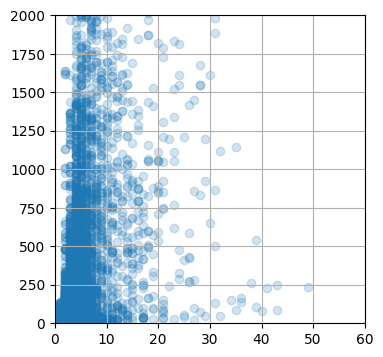

In [97]:
# Plot stats about indices
abs_v = abs(v)
v_at_indices = abs_v[v0_idxs]
print(f"Local min/max indices: {v0_idxs.shape}")
print(np.mean(abs_v), np.median(abs_v), np.std(abs_v))
print(np.mean(v_at_indices), np.median(v_at_indices), np.std(v_at_indices))

min_dt = 5
min_dm = 100
idxs_filt = []
min_dts = []
min_dms = []
mag_chunks = []
trav_chunks = []
for i in range(1, v0_idxs.shape[0] - 1):
    idx = v0_idxs[i]
    near_idxs = [v0_idxs[i-1], v0_idxs[i+1]]
    mag_i = mag[v0_idxs[i]]
    mag_near = mag[near_idxs]
    min_dm_i = min(abs(mag_near - mag_i))
    min_dt_i = min(abs(near_idxs - idx))
    min_dms.append(min_dm_i)
    min_dts.append(min_dt_i)
    if min_dt_i < min_dt:
        continue
    if min_dm_i < min_dm:
        continue
    idxs_filt.append(idx)
print(f"Filtered local min/max indices: {len(idxs_filt)}")

v_at_indices = abs_v[idxs_filt]
print(np.mean(v_at_indices), np.median(v_at_indices), np.std(v_at_indices))

plt.figure(figsize=(4, 4))
plt.scatter(min_dts, min_dms, alpha=0.2)
plt.ylim((0, 2000))
plt.xlim((0, 60))
plt.grid()


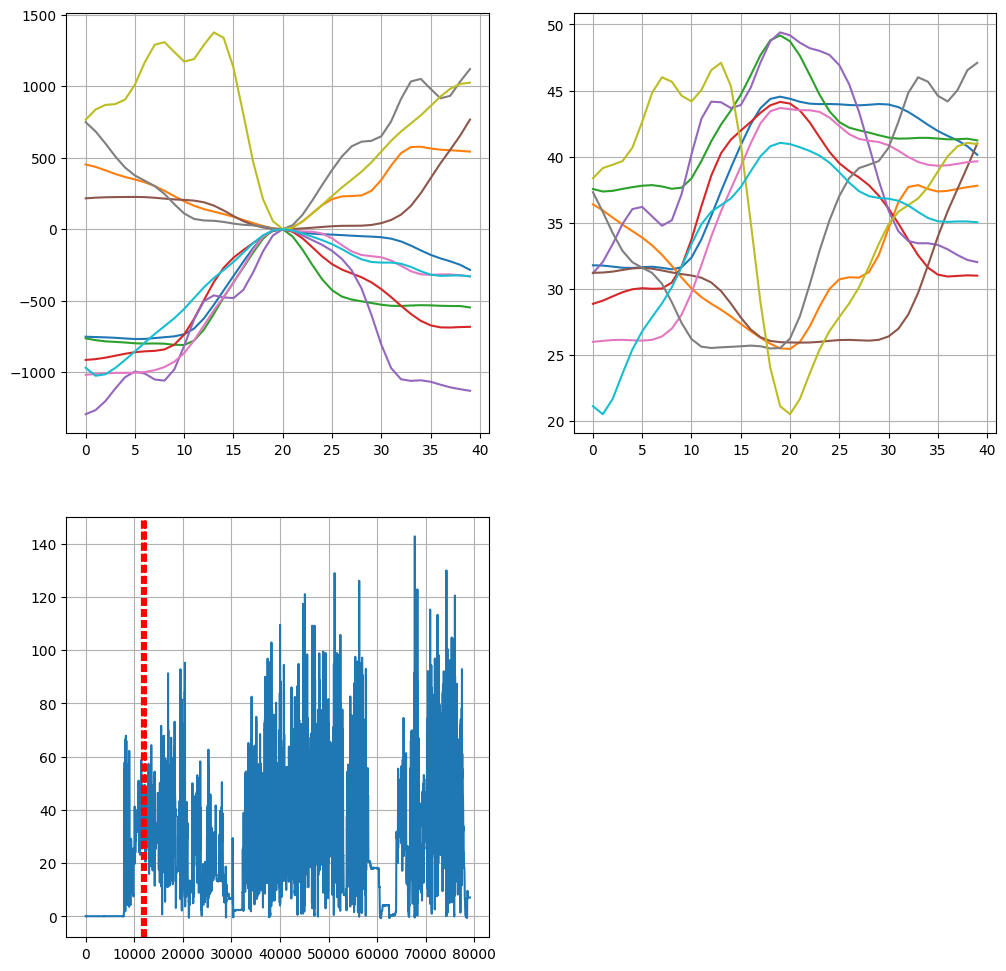

In [98]:
def get_chunks(idxes, width=20):
    mag_chunks = []
    trav_chunks = []
    for idx in idxes:
        mag_chunks.append(mag[idx - width:idx + width] - mag[idx])
        trav_chunks.append(travel[idx - width:idx + width])
    return mag_chunks, trav_chunks

roi_start = 20
roi_len = 10
plt.figure(figsize=(12, 12))
mag_chunks, trav_chunks = get_chunks(idxs_filt[roi_start:roi_start + roi_len])
plt.subplot(2, 2, 1)
for i in range(len(mag_chunks)):
    plt.plot(mag_chunks[i])
plt.grid()
plt.subplot(2, 2, 2)
for i in range(len(trav_chunks)):
    plt.plot(trav_chunks[i])
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(travel)
for idx in idxs_filt[roi_start:roi_start + roi_len]:
    plt.axvline(x=idx, color='r', linestyle='--')
plt.grid()